In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction
from FrequencyAbstraction import FourierTransformation
from sklearn.cluster import KMeans

In [25]:
# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------

df = pd.read_pickle("../../data/interim/02_outliers_removed_chauvenets.pkl")

print(df.head())

predictor_columns = list(df.columns[:6])

                            acc_x     acc_y     acc_z   gyr_x   gyr_y   gyr_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   

                        participant  label category  set  
epoch (ms)                                                
2019-01-11 15:08:05.200           B  bench    heavy   30  
2019-01-11 15:08:05.400           B  bench    heavy   30  
2019-01-11 15:08:05.600           B  bench    heavy   30  
2019-01-11 15:08:05.800           B  bench    heavy   30  
2019-01-11 15:08:06.000           B  bench    heavy   30  


In [26]:
# --------------------------------------------------------------
# Plot Settings
# --------------------------------------------------------------

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [27]:
# --------------------------------------------------------------
# Dealing with missing values (imputation)
# --------------------------------------------------------------

print(df.info())

for col in predictor_columns:
  df[col] = df[col].interpolate()

print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-nu

16
epoch (ms)
2019-01-11 15:08:05.200    16.0
2019-01-11 15:08:05.400    16.0
2019-01-11 15:08:05.600    16.0
2019-01-11 15:08:05.800    16.0
2019-01-11 15:08:06.000    16.0
Name: duration, dtype: float64
category
heavy       14.743501
medium      24.942529
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64
2.9487001733102254
2.4942528735632186


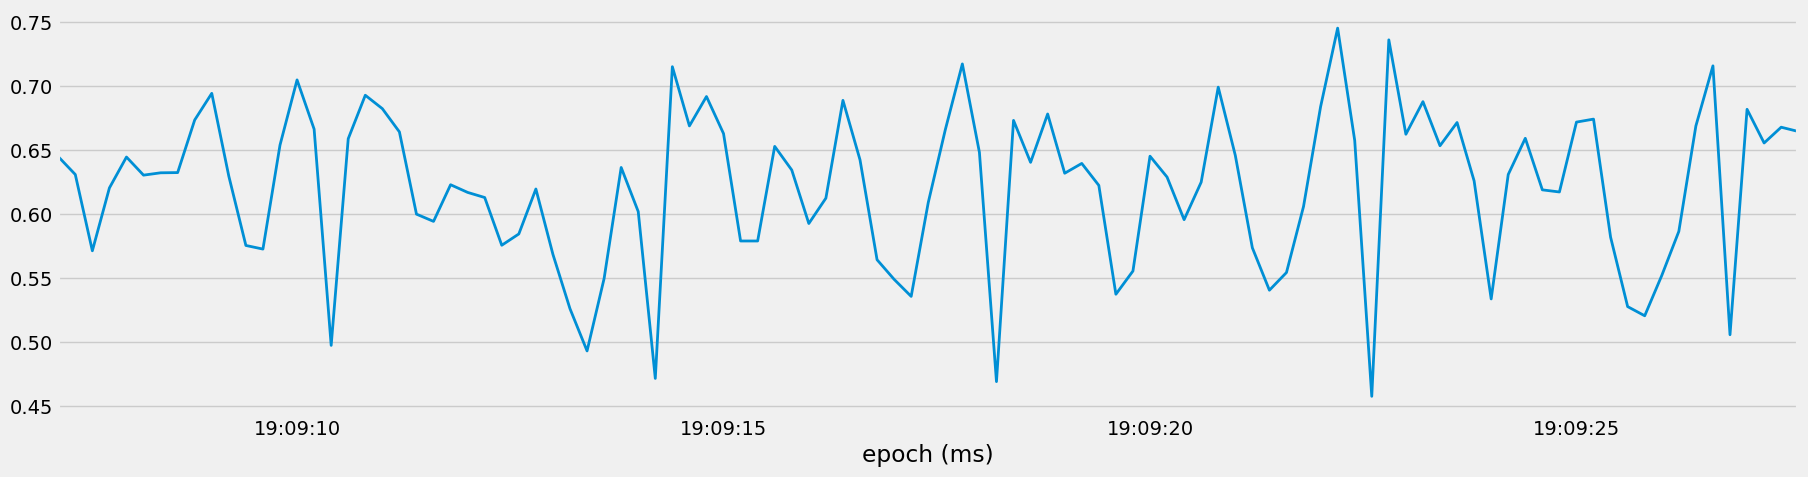

In [28]:
# --------------------------------------------------------------
# Calculating set duration
# --------------------------------------------------------------

df[df["set"] == 25]["acc_y"].plot()
# df[df["set"] == 50]["acc_y"].plot()

duration = df[df["set"] == 1].index[-1] - df[df["set"] == 1].index[0]
print(duration.seconds)

sets = df["set"].unique()

# We calc the exercise's time for each set
for set in sets:
  start = df[df["set"] == set].index[0]
  stop = df[df["set"] == set].index[-1]

  duration = stop - start
  df.loc[(df["set"] == set), "duration"] = duration.seconds

# Get average time for each category
duration_df = df.groupby(["category"])["duration"].mean()

print(df["duration"].head())
print(duration_df)

# Get average time for each count for Heavey and Medium erxercises
print(duration_df.iloc[0] / 5) # We divide by expected number of counts the participant can do for Heavy exercise
print(duration_df.iloc[1] / 10) # We divide by expected number of counts the participant can do for Medium exercise

C:\Users\Moham\AppData\Local\Temp\ipykernel_8164\2768965935.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(subset["label"][0])


ohp
                            acc_x     acc_y     acc_z     gyr_x     gyr_y  \
epoch (ms)                                                                  
2019-01-11 15:08:05.200  0.013494  0.977001 -0.070995 -1.896395  2.439080   
2019-01-11 15:08:05.400  0.006869  0.970257 -0.067545  2.129685  0.528678   
2019-01-11 15:08:05.600 -0.009603  0.963589 -0.073447  4.151973 -2.092258   
2019-01-11 15:08:05.800 -0.022998  0.965441 -0.083731  2.074477 -3.626288   
2019-01-11 15:08:06.000 -0.020032  0.966784 -0.093783  1.041930 -1.219897   

                            gyr_z participant  label category  set  duration  
epoch (ms)                                                                    
2019-01-11 15:08:05.200  0.939616           B  bench    heavy   30      16.0  
2019-01-11 15:08:05.400 -1.248135           B  bench    heavy   30      16.0  
2019-01-11 15:08:05.600 -0.929804           B  bench    heavy   30      16.0  
2019-01-11 15:08:05.800  0.880509           B  bench    heavy

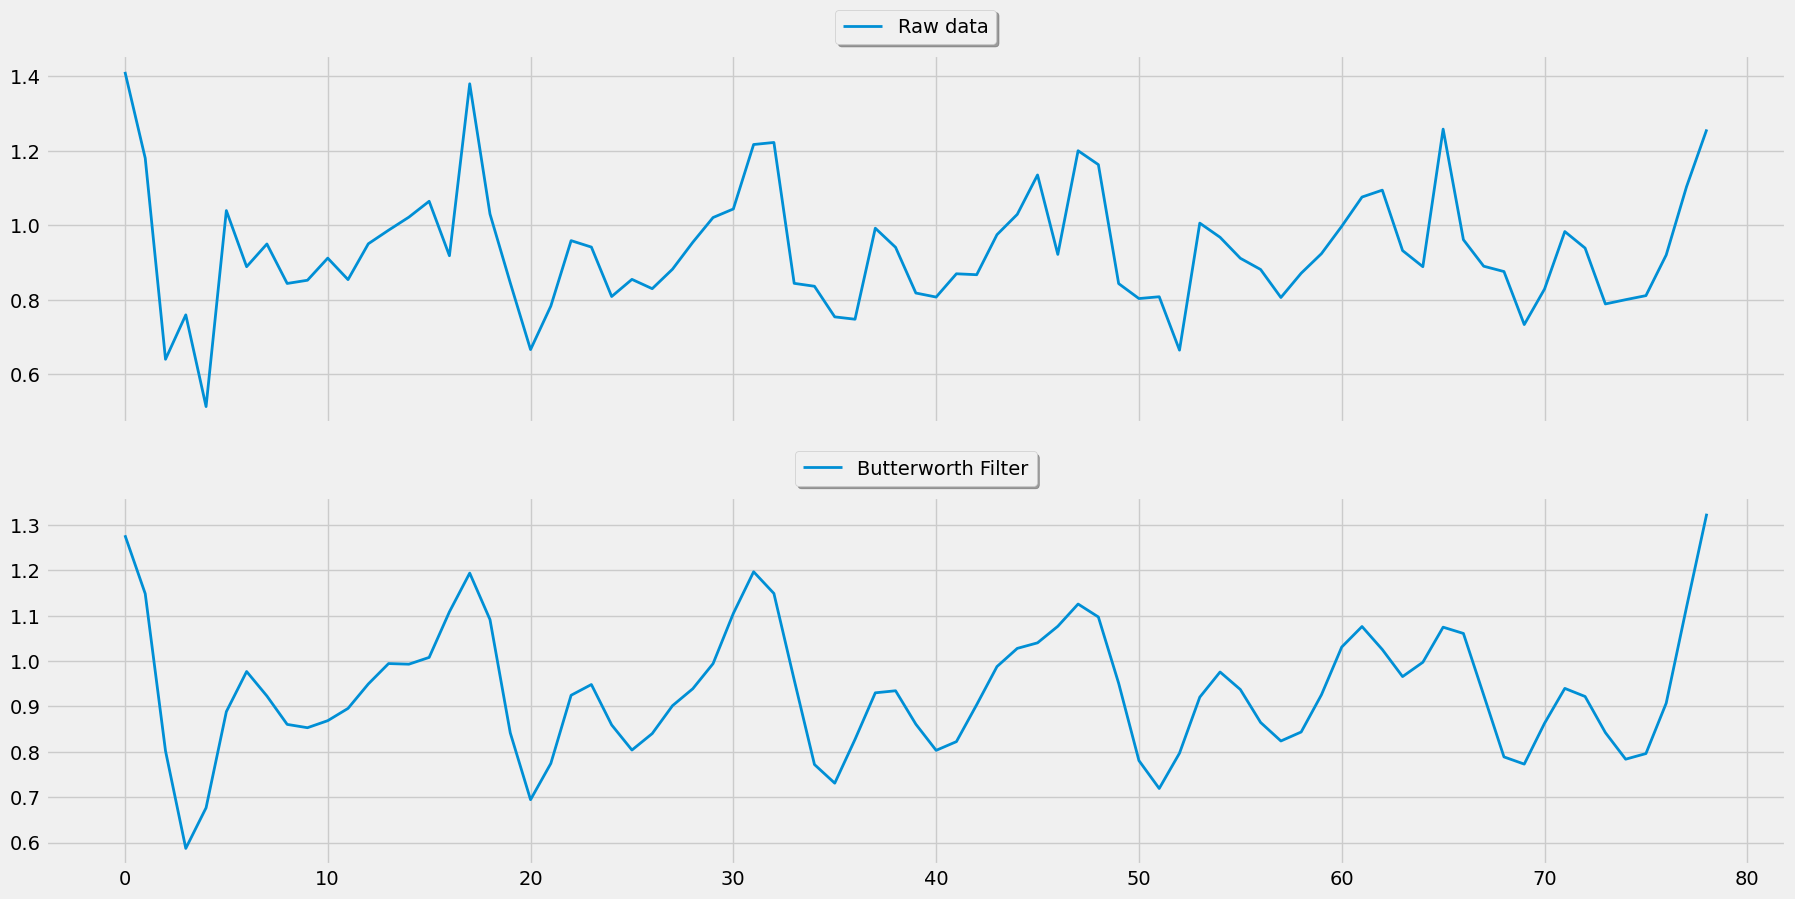

In [29]:
# --------------------------------------------------------------
# Butterworth lowpass filter
# --------------------------------------------------------------

df_lowpass = df.copy()
LowPass = LowPassFilter()

fs = 1000 / 200
cutoff = 1.2

df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)
subset = df_lowpass[df_lowpass["set"] == 45]
print(subset["label"][0])

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="Raw data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="Butterworth Filter")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)

df_lowpass = df.copy()
for col in predictor_columns:
  df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
  df_lowpass[col] = df_lowpass[col + "_lowpass"]
  del df_lowpass[col + "_lowpass"]


print(df_lowpass.head())

[0.58094932 0.27090665 0.06427472 0.05519685 0.01836808 0.01030437]


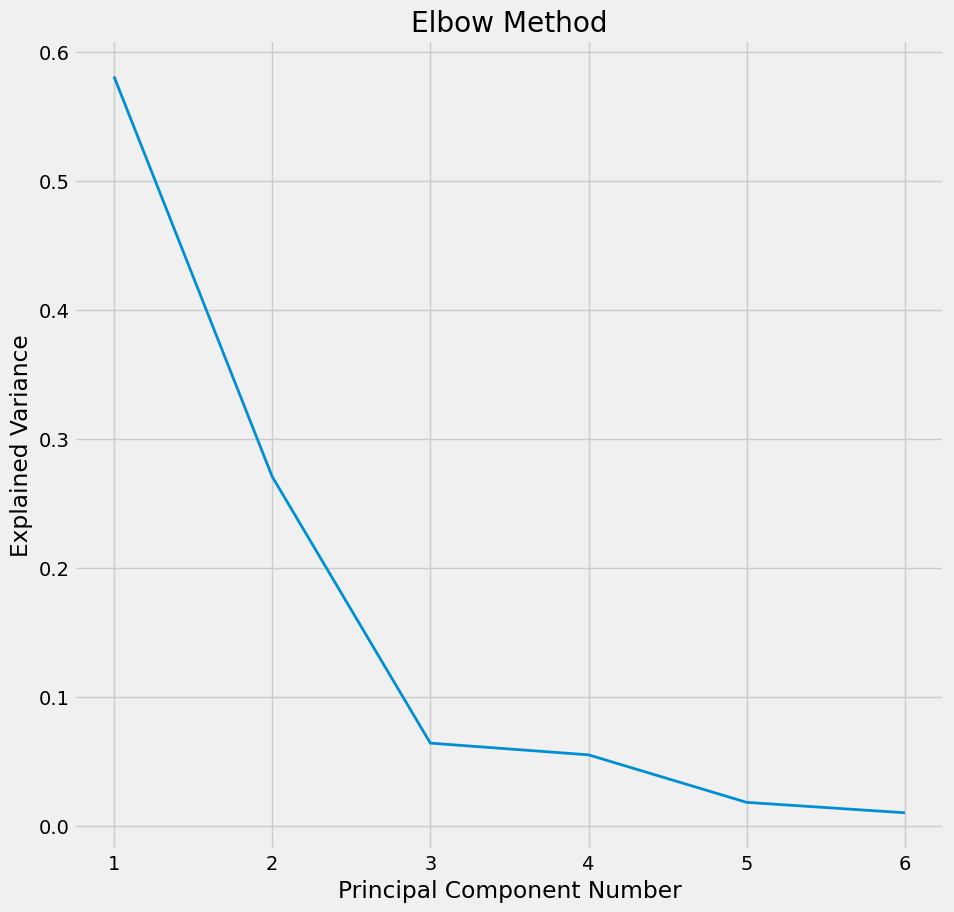

                            acc_x     acc_y     acc_z     gyr_x     gyr_y  \
epoch (ms)                                                                  
2019-01-11 15:08:05.200  0.013494  0.977001 -0.070995 -1.896395  2.439080   
2019-01-11 15:08:05.400  0.006869  0.970257 -0.067545  2.129685  0.528678   
2019-01-11 15:08:05.600 -0.009603  0.963589 -0.073447  4.151973 -2.092258   
2019-01-11 15:08:05.800 -0.022998  0.965441 -0.083731  2.074477 -3.626288   
2019-01-11 15:08:06.000 -0.020032  0.966784 -0.093783  1.041930 -1.219897   

                            gyr_z participant  label category  set  duration  \
epoch (ms)                                                                     
2019-01-11 15:08:05.200  0.939616           B  bench    heavy   30      16.0   
2019-01-11 15:08:05.400 -1.248135           B  bench    heavy   30      16.0   
2019-01-11 15:08:05.600 -0.929804           B  bench    heavy   30      16.0   
2019-01-11 15:08:05.800  0.880509           B  bench    heav

<Axes: xlabel='epoch (ms)'>

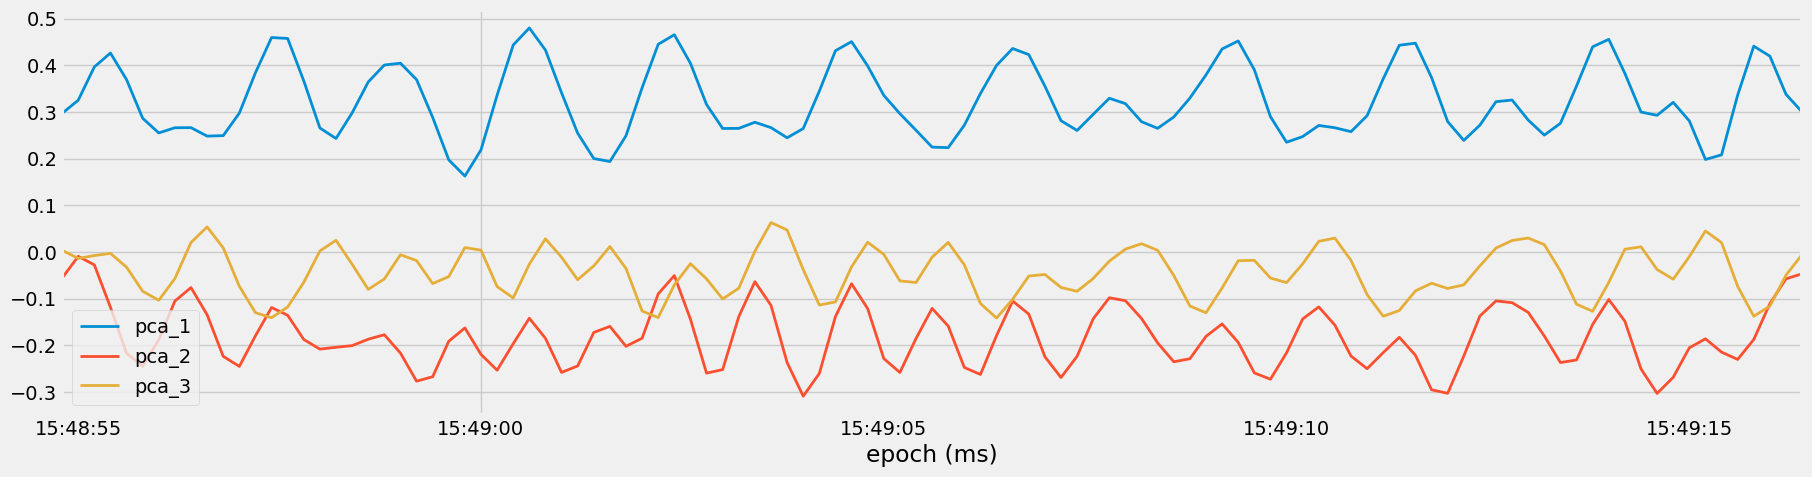

In [30]:
# --------------------------------------------------------------
# Principal component analysis PCA
# --------------------------------------------------------------

df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()

pc_values = PCA.determine_pc_explained_variance(df_pca, predictor_columns)
print(pc_values)

plt.figure(figsize=(10, 10))
plt.plot(range(1, len(predictor_columns) + 1), pc_values)
plt.title("Elbow Method")
plt.xlabel("Principal Component Number")
plt.ylabel("Explained Variance")
plt.show()

df_pca = PCA.apply_pca(df_pca, predictor_columns, 3)
print(df_pca.head())

subset = df_pca[df_pca["set"] == 35]
subset[["pca_1", "pca_2", "pca_3"]].plot()

                            acc_x     acc_y     acc_z     gyr_x     gyr_y  \
epoch (ms)                                                                  
2019-01-11 15:08:05.200  0.013494  0.977001 -0.070995 -1.896395  2.439080   
2019-01-11 15:08:05.400  0.006869  0.970257 -0.067545  2.129685  0.528678   
2019-01-11 15:08:05.600 -0.009603  0.963589 -0.073447  4.151973 -2.092258   
2019-01-11 15:08:05.800 -0.022998  0.965441 -0.083731  2.074477 -3.626288   
2019-01-11 15:08:06.000 -0.020032  0.966784 -0.093783  1.041930 -1.219897   

                            gyr_z participant  label category  set  duration  \
epoch (ms)                                                                     
2019-01-11 15:08:05.200  0.939616           B  bench    heavy   30      16.0   
2019-01-11 15:08:05.400 -1.248135           B  bench    heavy   30      16.0   
2019-01-11 15:08:05.600 -0.929804           B  bench    heavy   30      16.0   
2019-01-11 15:08:05.800  0.880509           B  bench    heav

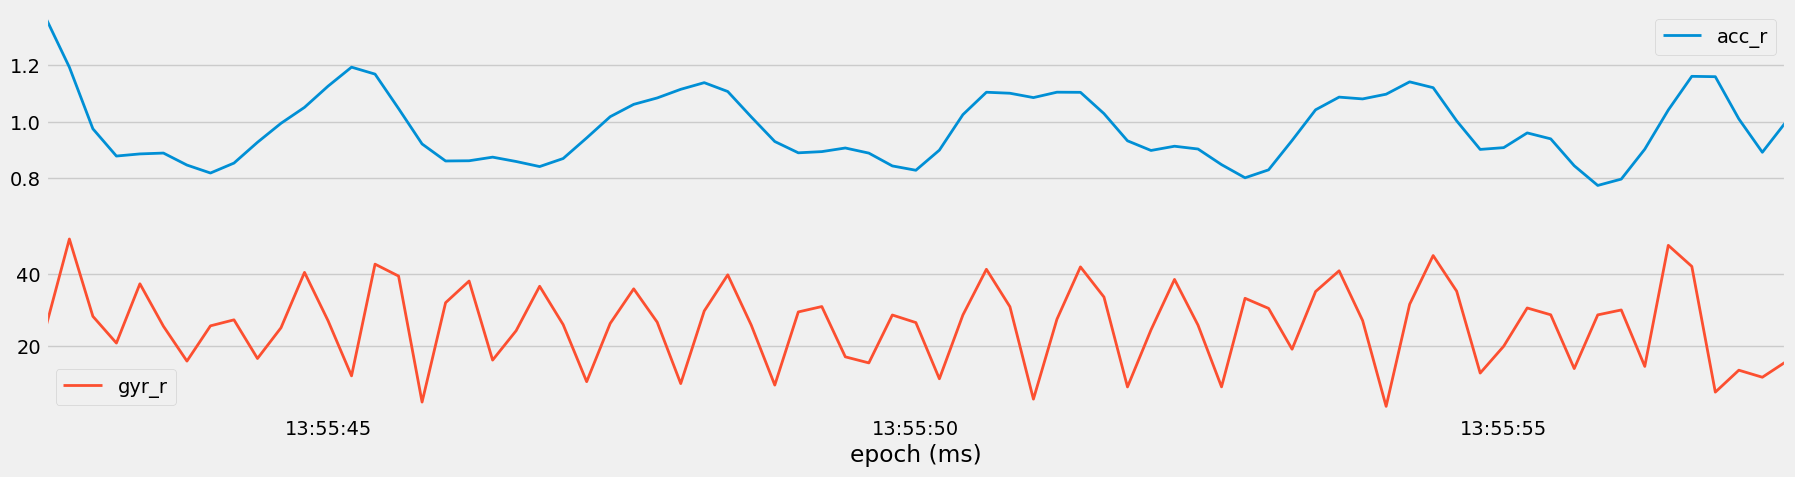

In [31]:
# --------------------------------------------------------------
# Sum of squares attributes
# --------------------------------------------------------------

df_squared = df_pca.copy()

acc_r = df_squared["acc_x"] ** 2 + df_squared["acc_y"] ** 2 + df_squared["acc_z"] ** 2
gyr_r = df_squared["gyr_x"] ** 2 + df_squared["gyr_y"] ** 2 + df_squared["gyr_z"] ** 2

df_squared["acc_r"] = np.sqrt(acc_r)
df_squared["gyr_r"] = np.sqrt(gyr_r)

subset = df_squared[df_squared["set"] == 14]
subset[["acc_r", "gyr_r"]].plot(subplots=True)

print(df_squared.head())

                            acc_x     acc_y     acc_z     gyr_x     gyr_y  \
epoch (ms)                                                                  
2019-01-11 15:08:05.200  0.013494  0.977001 -0.070995 -1.896395  2.439080   
2019-01-11 15:08:05.400  0.006869  0.970257 -0.067545  2.129685  0.528678   
2019-01-11 15:08:05.600 -0.009603  0.963589 -0.073447  4.151973 -2.092258   
2019-01-11 15:08:05.800 -0.022998  0.965441 -0.083731  2.074477 -3.626288   
2019-01-11 15:08:06.000 -0.020032  0.966784 -0.093783  1.041930 -1.219897   

                            gyr_z participant  label category  set  ...  \
epoch (ms)                                                          ...   
2019-01-11 15:08:05.200  0.939616           B  bench    heavy   30  ...   
2019-01-11 15:08:05.400 -1.248135           B  bench    heavy   30  ...   
2019-01-11 15:08:05.600 -0.929804           B  bench    heavy   30  ...   
2019-01-11 15:08:05.800  0.880509           B  bench    heavy   30  ...   
2019-01-11

<Axes: xlabel='epoch (ms)'>

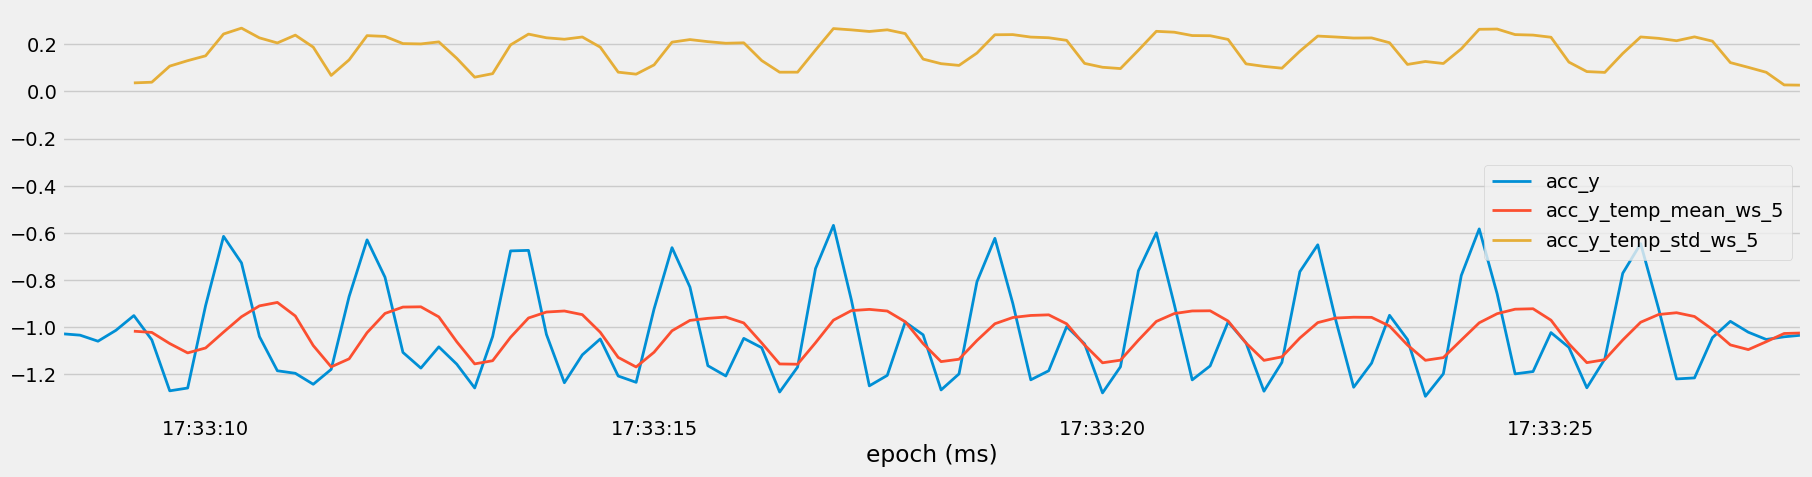

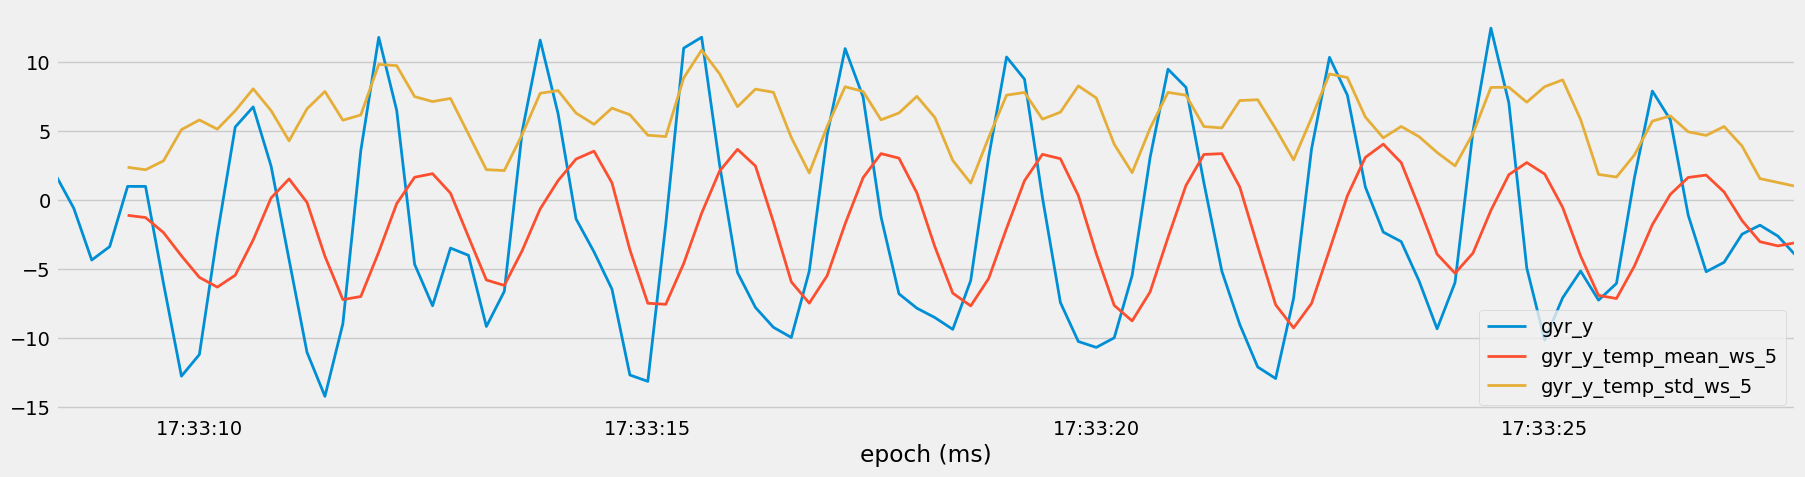

In [32]:
# --------------------------------------------------------------
# Temporal abstraction
# --------------------------------------------------------------

df_temporal = df_squared.copy()
NumAbs = NumericalAbstraction()

predictor_columns += ["acc_r", "gyr_r"]
ws = int(1000/200)

# for col in predictor_columns:
#   df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, "mean")
#   df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, "std")

df_temporal_list = []
sets = df_temporal["set"].unique()

for set in sets:
  subset = df_temporal[df_temporal["set"] == set].copy()
  for col in predictor_columns:
    subset = NumAbs.abstract_numerical(subset, [col], ws, "mean")
    subset = NumAbs.abstract_numerical(subset, [col], ws, "std")
  df_temporal_list.append(subset)

df_temporal = pd.concat(df_temporal_list)

print(df_temporal.head())

subset[["acc_y", "acc_y_temp_mean_ws_5", "acc_y_temp_std_ws_5"]].plot()
subset[["gyr_y", "gyr_y_temp_mean_ws_5", "gyr_y_temp_std_ws_5"]].plot()

Applying Fourier Transformation to set 30
Applying Fourier Transformation to set 1
Applying Fourier Transformation to set 31
Applying Fourier Transformation to set 3
Applying Fourier Transformation to set 9
Applying Fourier Transformation to set 32
Applying Fourier Transformation to set 10
Applying Fourier Transformation to set 33
Applying Fourier Transformation to set 11
Applying Fourier Transformation to set 34
Applying Fourier Transformation to set 35
Applying Fourier Transformation to set 15
Applying Fourier Transformation to set 36
Applying Fourier Transformation to set 16
Applying Fourier Transformation to set 37
Applying Fourier Transformation to set 17
Applying Fourier Transformation to set 27
Applying Fourier Transformation to set 38
Applying Fourier Transformation to set 28
Applying Fourier Transformation to set 29
Applying Fourier Transformation to set 6
Applying Fourier Transformation to set 65
Applying Fourier Transformation to set 67
Applying Fourier Transformation to set

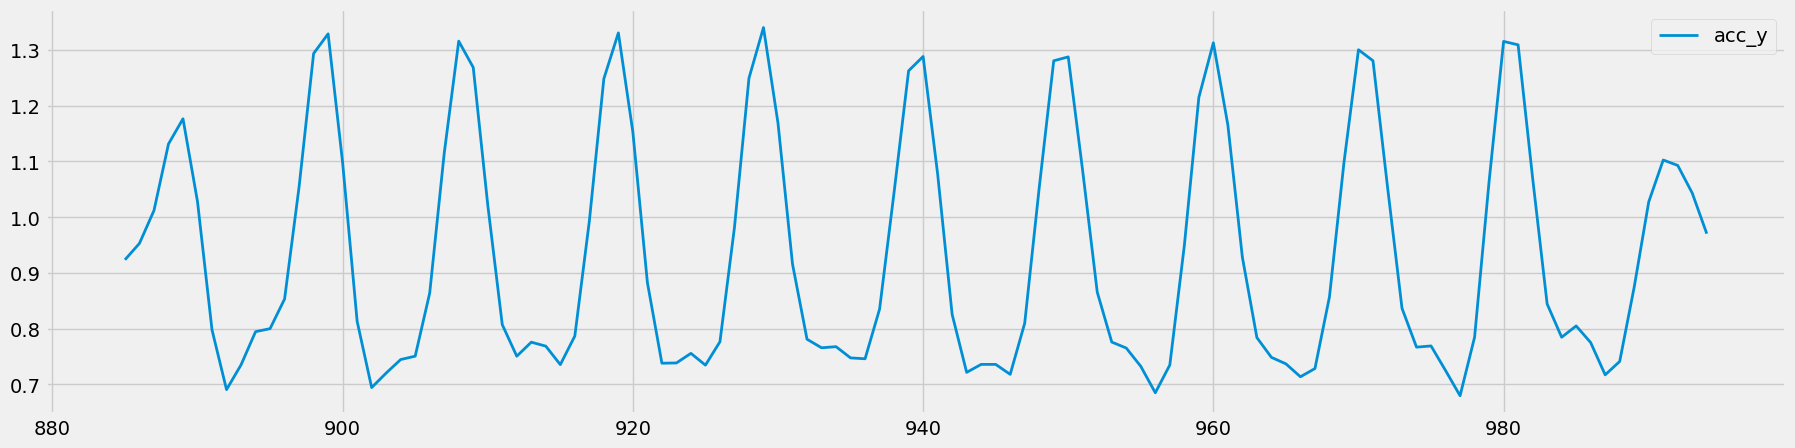

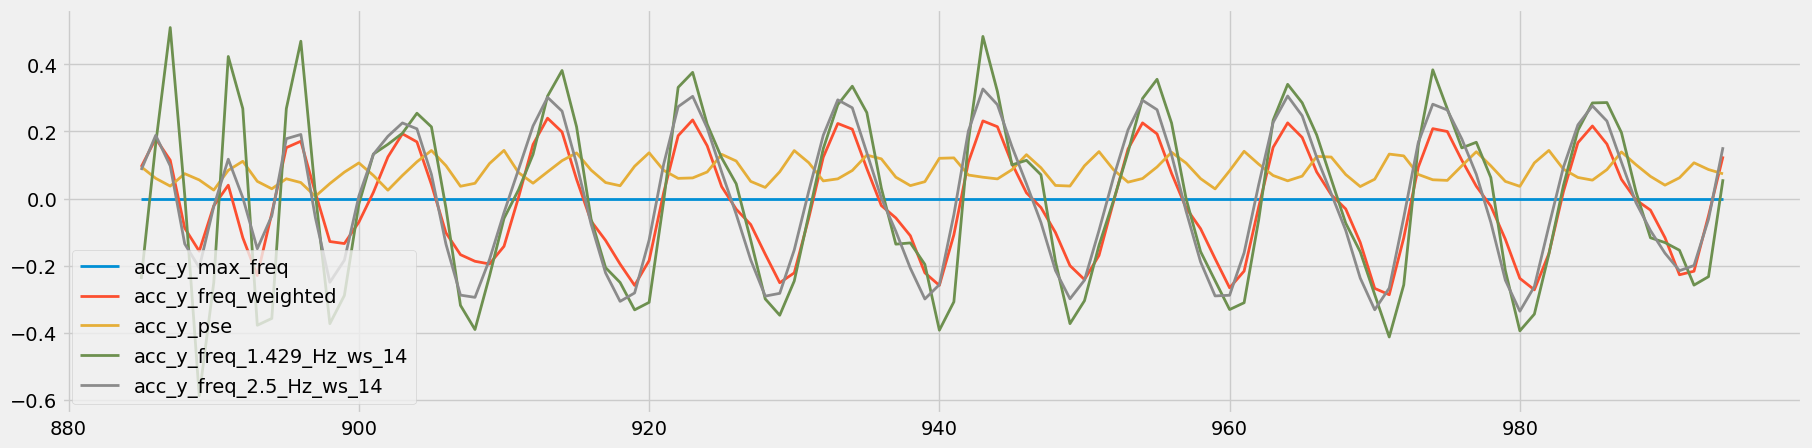

In [48]:
# --------------------------------------------------------------
# Frequency features
# --------------------------------------------------------------

df_freq = df_temporal.copy().reset_index()
FreqAbs = FourierTransformation()

fs = int(1000 / 200)
ws = int(2800 / 200)

df_freq_plot = FreqAbs.abstract_frequency(df_freq, ["acc_y"], ws, fs)

subset = df_freq_plot[df_freq_plot["set"] == 15]
subset[["acc_y"]].plot()
subset[
  [
    "acc_y_max_freq",
    "acc_y_freq_weighted",
    "acc_y_pse",
    "acc_y_freq_1.429_Hz_ws_14",
    "acc_y_freq_2.5_Hz_ws_14",
  ]
].plot()

df_freq = df_temporal.copy().reset_index()
df_freq_list = []
for set in df_freq["set"].unique():
  print(f"Applying Fourier Transformation to set {set}")
  subset = df_freq[df_freq["set"] == set].reset_index(drop=True).copy()
  subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, fs)
  df_freq_list.append(subset)

df_freq = pd.concat(df_freq_list).set_index("epoch (ms)", drop=True)

print(df_freq)

In [49]:
# --------------------------------------------------------------
# Dealing with overlapping windows
# --------------------------------------------------------------

df_freq = df_freq.dropna()

# To reduce the correlation between rows (Which may lead to overfitting), we one row from each 2 rows to decrease the correlation between rows
df_freq = df_freq.iloc[::2]

print(df_freq)

                            acc_x     acc_y     acc_z      gyr_x      gyr_y  \
epoch (ms)                                                                    
2019-01-11 15:08:08.000 -0.170494  0.888970 -0.172353 -25.990313 -10.162423   
2019-01-11 15:08:08.400 -0.027634  0.878027 -0.056321  -4.311919  -1.963210   
2019-01-11 15:08:08.800 -0.060139  0.982341 -0.036019   3.691356  -1.273743   
2019-01-11 15:08:09.200 -0.048152  0.984179 -0.036625  -0.251944  -3.967927   
2019-01-11 15:08:09.600 -0.043981  0.900329 -0.056932  11.319237   5.163204   
...                           ...       ...       ...        ...        ...   
2019-01-20 17:33:26.200  0.061740 -0.921306  0.112441 -36.980345   7.916154   
2019-01-20 17:33:26.600 -0.022066 -1.214770 -0.111567  -4.451577  -1.081130   
2019-01-20 17:33:27.000 -0.045056 -0.974791 -0.061752   3.273522  -4.487268   
2019-01-20 17:33:27.400 -0.047074 -1.051656 -0.066326  -0.673530  -1.799975   
2019-01-20 17:33:27.800 -0.043963 -1.033252 -0.05867

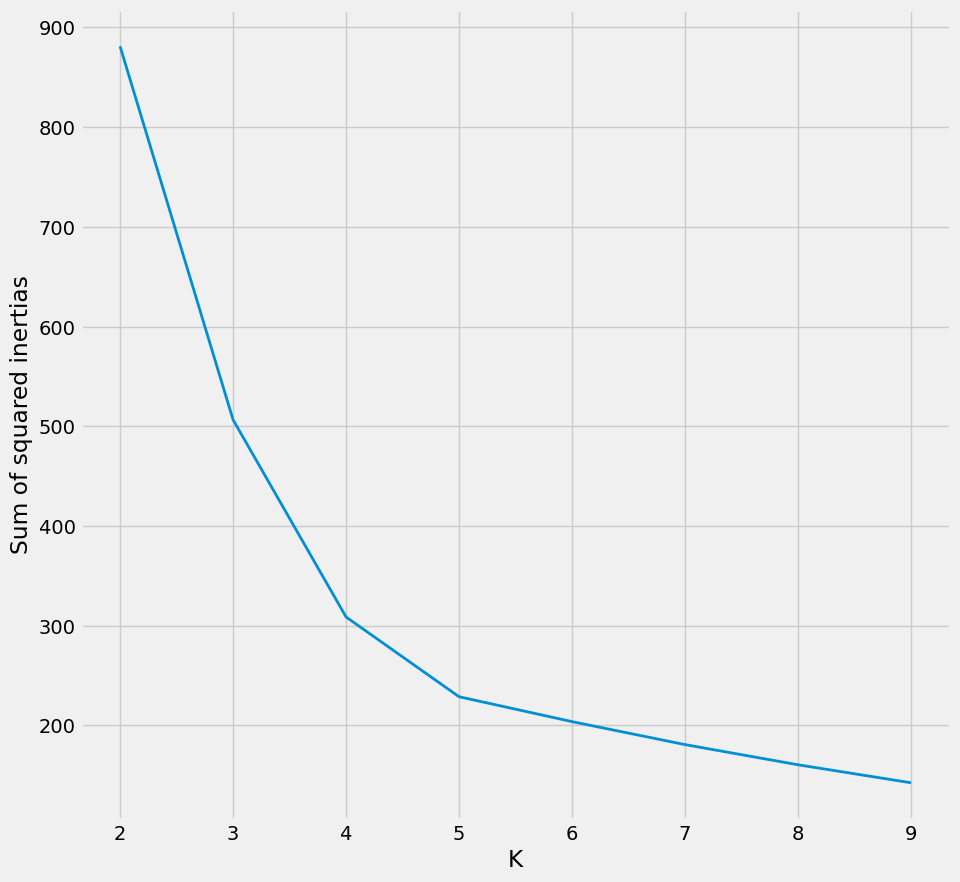

epoch (ms)
2019-01-11 15:08:08.000    1
2019-01-11 15:08:08.400    1
2019-01-11 15:08:08.800    1
2019-01-11 15:08:09.200    1
2019-01-11 15:08:09.600    1
                          ..
2019-01-20 17:33:26.200    3
2019-01-20 17:33:26.600    0
2019-01-20 17:33:27.000    0
2019-01-20 17:33:27.400    0
2019-01-20 17:33:27.800    0
Name: cluster, Length: 3868, dtype: int32


In [56]:
# --------------------------------------------------------------
# Clustering
# --------------------------------------------------------------

df_cluster = df_freq.copy()

cluster_columns = ["acc_x", "acc_y", "acc_z"]
k_values = range(2, 10)
inertias = []

for k in k_values:
  subset = df_cluster[cluster_columns]
  kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
  cluster_labels = kmeans.fit_predict(subset)
  inertias.append(kmeans.inertia_)


plt.figure(figsize=(10, 10))
plt.plot(k_values, inertias)
plt.xlabel("K")
plt.ylabel("Sum of squared inertias")
plt.show()

kmeans = KMeans(n_clusters=5, n_init=20, random_state=0)
subset = df_cluster[cluster_columns]
df_cluster["cluster"] = kmeans.fit_predict(subset)

print(df_cluster["cluster"])

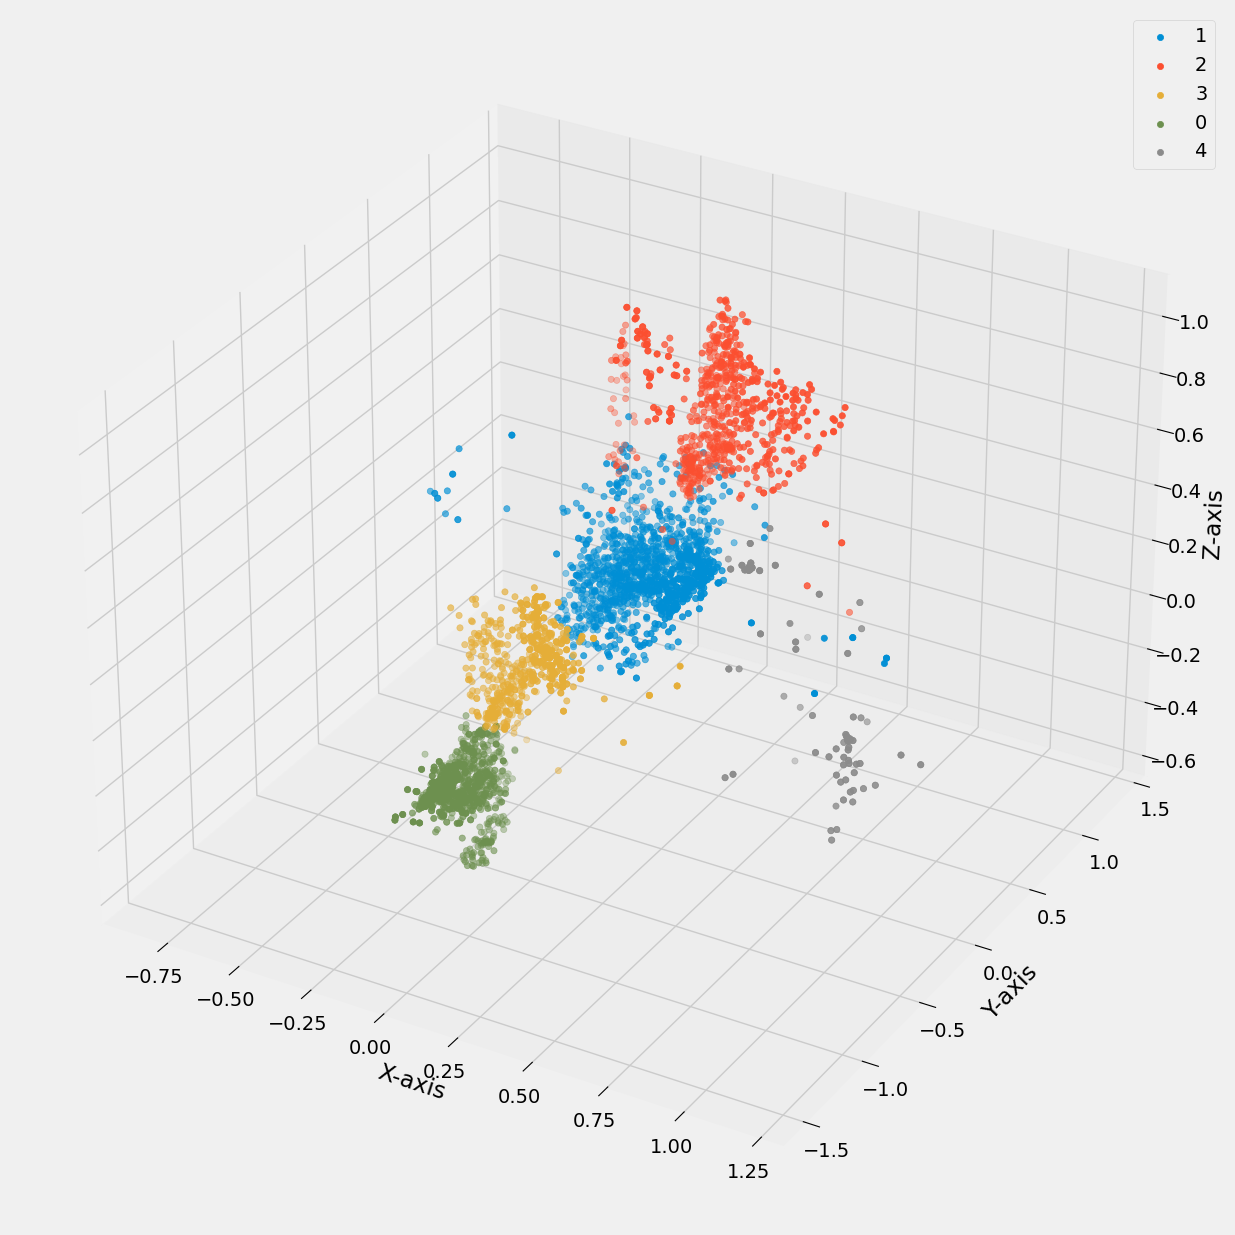

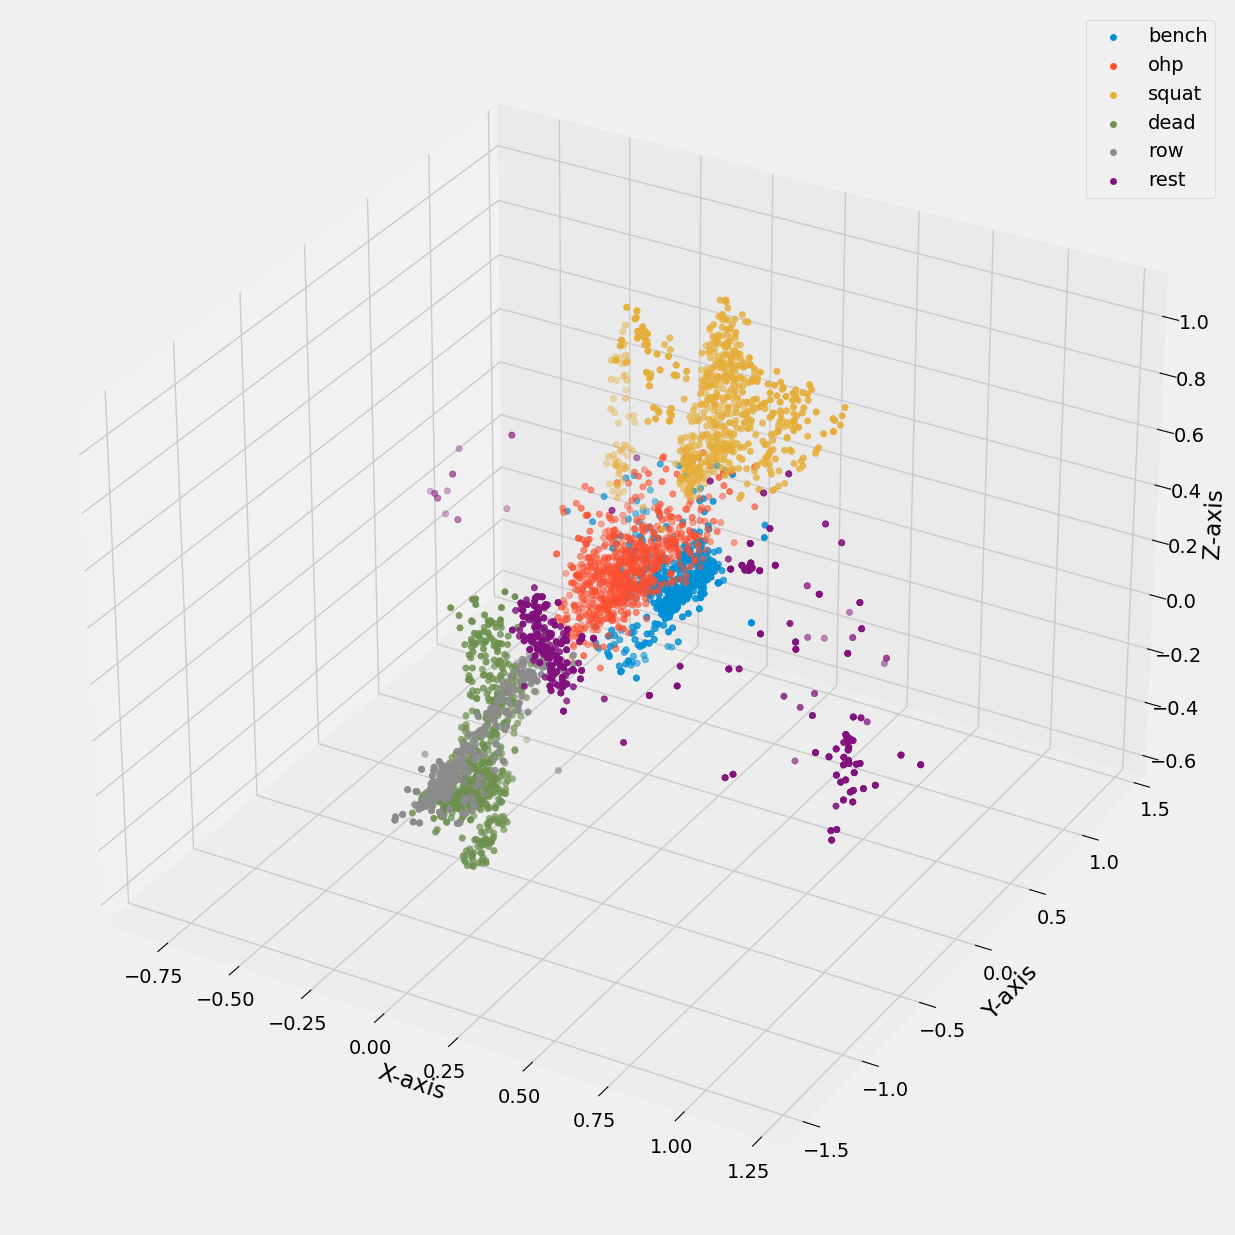

In [60]:
# --------------------------------------------------------------
# Plot normal Sets VS Cluster Sets
# --------------------------------------------------------------

# Cluster Sets
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection = "3d")
for c in df_cluster["cluster"].unique():
  subset = df_cluster[df_cluster["cluster"] == c]
  ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label = c)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()

# Normal Sets
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection = "3d")
for c in df_cluster["label"].unique():
  subset = df_cluster[df_cluster["label"] == c]
  ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label = c)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()

In [62]:
# --------------------------------------------------------------
# Export dataset
# --------------------------------------------------------------

df_cluster.to_pickle("../../data/interim/03_data_features.pkl")